In [1]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np

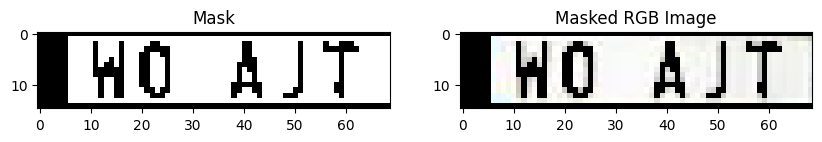

In [2]:
def create_mask(rgb_image):
    # Convert RGB image to HSV color space
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Define thresholds for each channel based on the provided values
    channel1_min = 0
    channel1_max = 180  # OpenCV uses 0-180 for hue
    channel2_min = 0
    channel2_max = int(0.129 * 255)
    channel3_min = int(0.781 * 255)
    channel3_max = 255
    
    # Create mask based on the defined thresholds
    mask = cv2.inRange(hsv_image, (channel1_min, channel2_min, channel3_min), (channel1_max, channel2_max, channel3_max))
    
    # Apply the mask to the original RGB image
    masked_rgb_image = cv2.bitwise_and(rgb_image, rgb_image, mask=mask)
    
    return mask, masked_rgb_image

# Example usage:
# Load RGB image
rgb_image = cv2.imread('plate.png')
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Call the function to create the mask
mask, masked_rgb_image = create_mask(rgb_image)

# Display the mask and masked RGB image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(1, 2, 2)
plt.imshow(masked_rgb_image)
plt.title('Masked RGB Image')

plt.show()


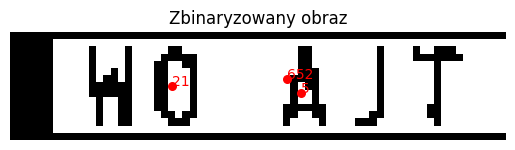

In [3]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask, connectivity=8)
# Wyświetlenie zbinaryzowanego obrazu
plt.imshow(mask, cmap='gray')
plt.title('Zbinaryzowany obraz')
plt.axis('off')

# Wyświetlenie składowych połączonych
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    plt.text(cx, cy, str(area), color='red')
    plt.scatter(cx, cy, color='red', s=30)
    
plt.show()

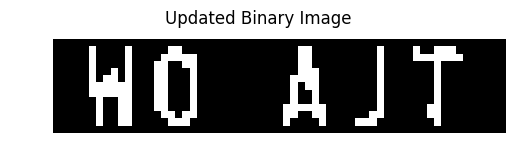

In [4]:
# Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

# Pobierz współrzędne centroidu o maksymalnym polu powierzchni
max_area_centroid = centroids[max_area_index]

updated_binary_image = np.copy(mask)
# Utwórz bounding box wokół centroidu z największym polem powierzchni
x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

# Wycięcie obszaru o największym polu powierzchni z binary_image
largest_component = np.zeros_like(mask)
largest_component[labels == max_area_index] = 255

# Nowa zmienna przechowująca obszary wewnątrz bounding boxa
updated_binary_image = np.copy(largest_component)

# Iteracja przez wszystkie etykiety poza tłem
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    
    # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
    if x <= cx <= x + w and y <= cy <= y + h:
        # Jeśli tak, dodaj obszar do updated_binary_image
        updated_binary_image[labels == i] = 255

inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
# Wyświetlenie zaktualizowanego binarnego obrazu
plt.imshow(inverted_updated_binary_image, cmap='gray')
plt.title('Updated Binary Image')
plt.axis('off')
plt.show()


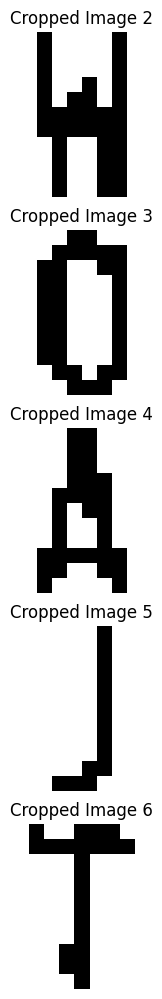

In [9]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

# Iterate through the connected components and display each cropped area except the largest
plt.figure(figsize=(15, 15))

for i in range(1, num_labels):
    if i == max_area_index:
        continue  # Skip the largest component
    
    x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
    cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
    cropped_image = cv.bitwise_not(cropped_image)
    plt.subplot(num_labels - 1, 1, i)
    plt.imshow(cropped_image, cmap='gray')
    plt.title(f'Cropped Image {i}')
    plt.axis('off')

plt.show()

In [10]:
def split(path):
    rgb_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    mask, masked_rgb_image = create_mask(rgb_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask, connectivity=8)
    # Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
    max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

    # Pobierz współrzędne centroidu o maksymalnym polu powierzchni
    max_area_centroid = centroids[max_area_index]

    updated_binary_image = np.copy(mask)
    # Utwórz bounding box wokół centroidu z największym polem powierzchni
    x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

    # Wycięcie obszaru o największym polu powierzchni z binary_image
    largest_component = np.zeros_like(mask)
    largest_component[labels == max_area_index] = 255

    # Nowa zmienna przechowująca obszary wewnątrz bounding boxa
    updated_binary_image = np.copy(largest_component)

    # Iteracja przez wszystkie etykiety poza tłem
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
        if x <= cx <= x + w and y <= cy <= y + h:
            # Jeśli tak, dodaj obszar do updated_binary_image
            updated_binary_image[labels == i] = 255

    inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

    # Iterate through the connected components and display each cropped area except the largest
    plt.figure(figsize=(15, 15))

    for i in range(1, num_labels):
        if i == max_area_index:
            continue  # Skip the largest component
        
        x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
        cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
        cropped_image = cv.bitwise_not(cropped_image)
        plt.subplot(num_labels - 1, 1, i)
        plt.imshow(cropped_image, cmap='gray')
        plt.title(f'Cropped Image {i}')
        plt.axis('off')

    plt.show()
    
    
    

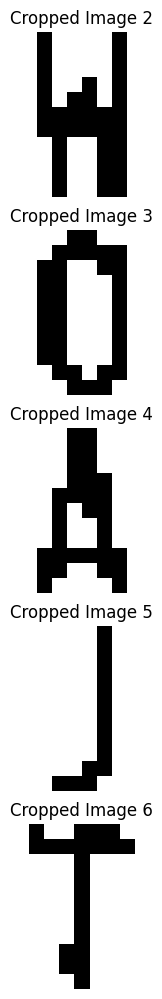

In [15]:
split("plate.png")

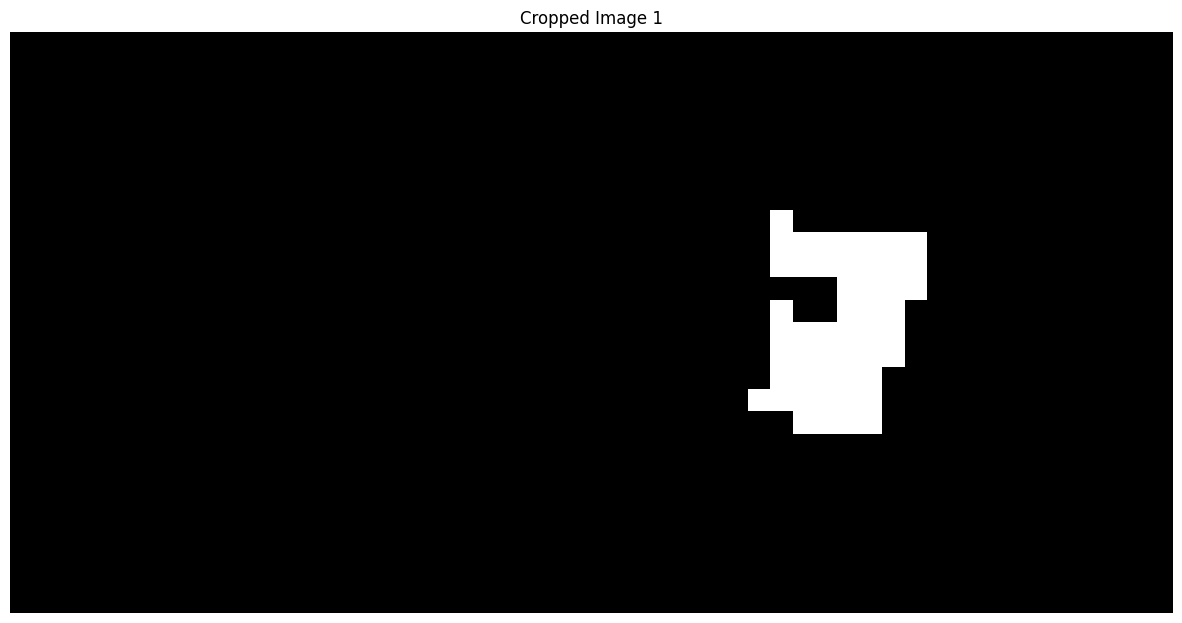

In [16]:
split("plate2.png")

In [17]:
split("plate3.png")

ValueError: attempt to get argmax of an empty sequence

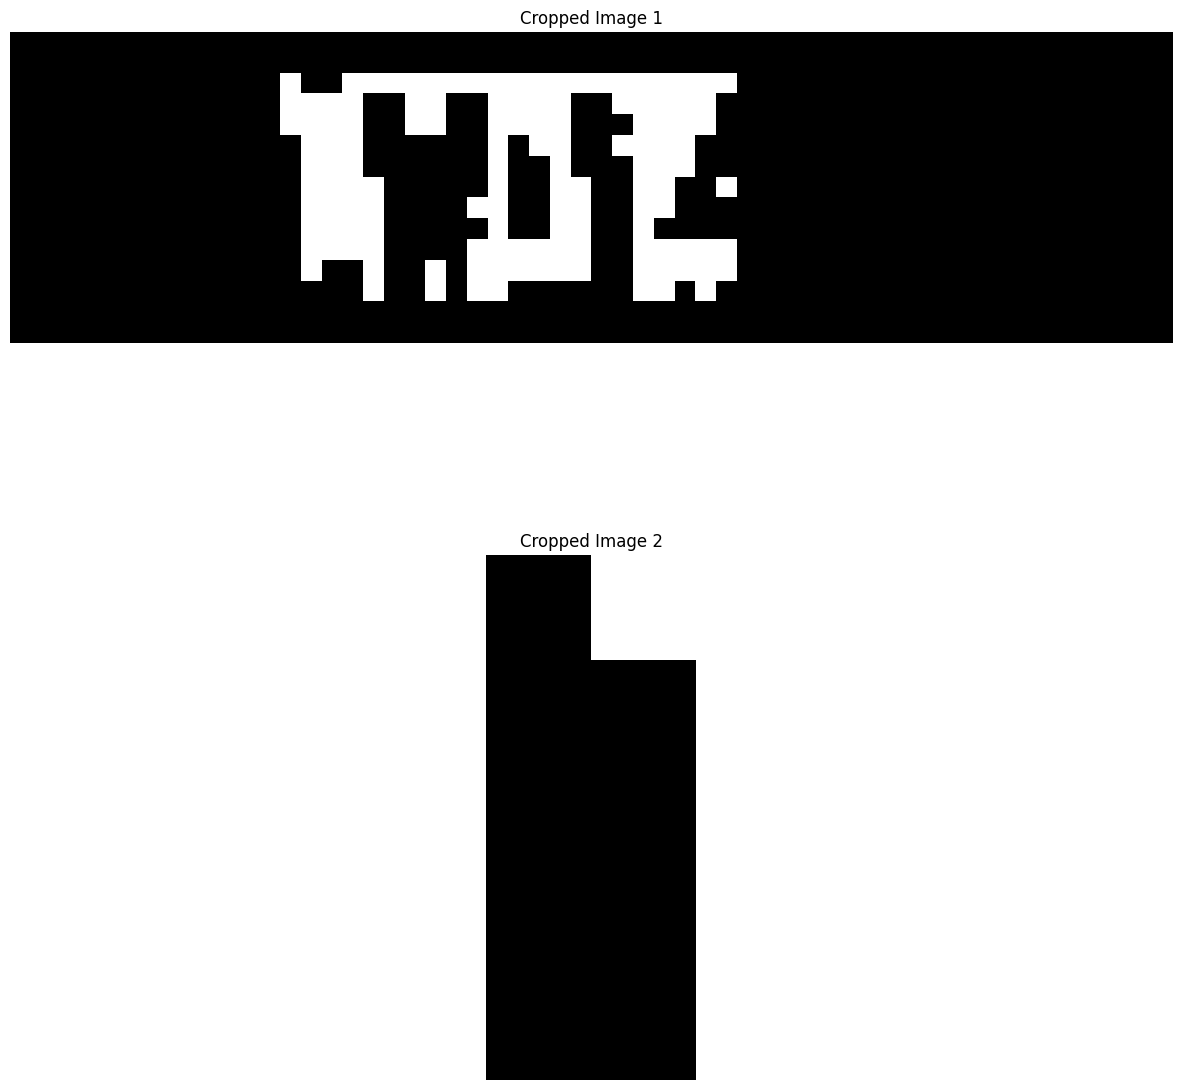

In [18]:
split("plate4.png")